In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import warnings
import optuna
import scipy.stats as st
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

c:\Users\jiahe\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test = pd.read_csv(r"C:\Users\jiahe\OneDrive\Desktop\kaggle\test.csv")
train = pd.read_csv(r"C:\Users\jiahe\OneDrive\Desktop\kaggle\train.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (517754, 14)
Test shape: (172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [3]:
train.isnull().sum().sort_values(ascending=False).head(10)

id                    0
road_type             0
num_lanes             0
curvature             0
speed_limit           0
lighting              0
weather               0
road_signs_present    0
public_road           0
time_of_day           0
dtype: int64

In [4]:
train_cat = train.copy()
test_cat = test.copy()

cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']

for col in cat_cols:
    categories = pd.Categorical(pd.concat([train_cat[col], test_cat[col]], axis=0)).categories
    train_cat[col] = pd.Categorical(train_cat[col], categories=categories)
    test_cat[col] = pd.Categorical(test_cat[col], categories=categories)

In [5]:
# List of categorical columns to target encode
target_encode_cols = ['road_type', 'lighting', 'weather', 'time_of_day']

# Initialize KFold for target encoding
kf = KFold(n_splits=5, shuffle=True, random_state=42)
encoded_features = pd.DataFrame(index=train.index)

for col in target_encode_cols:
    print(f"Target encoding: {col}")
    oof = pd.Series(np.nan, index=train.index)

    # Create out-of-fold mean for each category
    for train_idx, val_idx in kf.split(train):
        means = train.iloc[train_idx].groupby(col)['accident_risk'].mean()
        oof.iloc[val_idx] = train.iloc[val_idx][col].astype(str).map(means)


    encoded_features[col + '_te'] = oof

# Add encoded features to train
train = pd.concat([train, encoded_features], axis=1)

# Apply same encoding (using full-train mean) to test
for col in target_encode_cols:
    global_mean = train.groupby(col)['accident_risk'].mean()
    test[col + '_te'] = test[col].astype(str).map(global_mean)

Target encoding: road_type
Target encoding: lighting
Target encoding: weather
Target encoding: time_of_day


In [6]:
# =====================================================
# === Define baseline analytic function and clipper ===
# =====================================================
def f_base(X):
    """Simple analytic approximation of accident risk."""
    return (
        0.3 * X["curvature"]
        + 0.2 * (X["lighting"] == "night").astype(int)
        + 0.1 * (X["weather"] != "clear").astype(int)
        + 0.2 * (X["speed_limit"] >= 60).astype(int)
        + 0.1 * (X["num_reported_accidents"] > 2).astype(int)
    )

def clip(f, sigma=0.05):
    """Smoothly clip predictions into [0,1] using truncated normal expectation."""
    def clip_f(X):
        mu = f(X)
        a, b = -mu/sigma, (1 - mu)/sigma
        Phi_a, Phi_b = st.norm.cdf(a), st.norm.cdf(b)
        phi_a, phi_b = st.norm.pdf(a), st.norm.pdf(b)
        return mu*(Phi_b - Phi_a) + sigma*(phi_a - phi_b) + 1 - Phi_b
    return clip_f

# Apply baseline to train and test
train["y_base"] = clip(f_base)(train)
test["y_base"] = clip(f_base)(test)

# Compute residual target
train["y_resid"] = train["accident_risk"] - train["y_base"]

In [7]:
X = train_cat.drop(columns=['id', 'accident_risk'])
y = train['y_resid']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
importances = pd.DataFrame()
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_fs = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    model_fs.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping(100)]
    )

    fold_importance = pd.DataFrame({
        'feature': X.columns,
        'gain': model_fs.booster_.feature_importance(importance_type='gain'),
        'fold': fold + 1
    })
    importances = pd.concat([importances, fold_importance], axis=0)

# Compute feature importance
importance_df = (
    importances.groupby('feature')['gain']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Filter weak features
threshold = importance_df['gain'].median() * 0.1
selected_features = importance_df.query('gain > @threshold')['feature'].tolist()

print(f"✅ Selected {len(selected_features)} / {len(X.columns)} features after multi-fold averaging.")

# Reduce the dataset to selected features
X = X[selected_features]
test_X = test_cat[selected_features]

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info] Start training from score -0.000177
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0562943	valid_0's l2: 0.00316905
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info] Start training from score -0.000280
Trai

In [9]:
def objective(trial):
    params = {
        "n_estimators": 8000,
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 200),
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": -1
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[optuna.integration.LightGBMPruningCallback(trial, "rmse")]
        )
        preds = model.predict(X_val)
        mse = mean_squared_error(y_val, preds)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        
    return np.mean(rmse_scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("Best Params:", study.best_params)

best_params = study.best_params

[I 2025-10-28 16:22:33,338] A new study created in memory with name: no-name-87932734-9d99-479e-8b68-123d8632d6d0
Best trial: 0. Best value: 0.0561111:   2%|▎         | 1/40 [03:33<2:18:53, 213.68s/it]

[I 2025-10-28 16:26:07,014] Trial 0 finished with value: 0.05611105532733551 and parameters: {'learning_rate': 0.011227845563292689, 'num_leaves': 160, 'max_depth': 5, 'subsample': 0.6148754631475817, 'colsample_bytree': 0.8157015353520217, 'reg_alpha': 0.5036573683373882, 'reg_lambda': 0.8200201144051968, 'min_child_samples': 136}. Best is trial 0 with value: 0.05611105532733551.


Best trial: 1. Best value: 0.0560824:   5%|▌         | 2/40 [10:01<3:20:15, 316.20s/it]

[I 2025-10-28 16:32:34,971] Trial 1 finished with value: 0.056082405579342395 and parameters: {'learning_rate': 0.007800643091268933, 'num_leaves': 110, 'max_depth': 9, 'subsample': 0.6309077041052501, 'colsample_bytree': 0.6991487722337137, 'reg_alpha': 0.38476491312188366, 'reg_lambda': 0.7350972883910267, 'min_child_samples': 95}. Best is trial 1 with value: 0.056082405579342395.


Best trial: 1. Best value: 0.0560824:   8%|▊         | 3/40 [13:18<2:41:25, 261.77s/it]

[I 2025-10-28 16:35:51,978] Trial 2 finished with value: 0.05628613217125526 and parameters: {'learning_rate': 0.0069525602131742525, 'num_leaves': 150, 'max_depth': 4, 'subsample': 0.8722168492539175, 'colsample_bytree': 0.7060703724297954, 'reg_alpha': 0.19145654647888644, 'reg_lambda': 0.14157171305084415, 'min_child_samples': 183}. Best is trial 1 with value: 0.056082405579342395.


Best trial: 1. Best value: 0.0560824:  10%|█         | 4/40 [16:31<2:20:43, 234.55s/it]

[I 2025-10-28 16:39:04,793] Trial 3 finished with value: 0.05623694405589531 and parameters: {'learning_rate': 0.008877659358457295, 'num_leaves': 57, 'max_depth': 4, 'subsample': 0.6726010774556109, 'colsample_bytree': 0.626819192738186, 'reg_alpha': 0.1625601914654482, 'reg_lambda': 0.2658756523739906, 'min_child_samples': 43}. Best is trial 1 with value: 0.056082405579342395.


Best trial: 1. Best value: 0.0560824:  12%|█▎        | 5/40 [22:32<2:43:31, 280.33s/it]

[I 2025-10-28 16:45:06,289] Trial 4 finished with value: 0.05628310072903429 and parameters: {'learning_rate': 0.01763743225501276, 'num_leaves': 110, 'max_depth': 9, 'subsample': 0.7484038795390853, 'colsample_bytree': 0.7797848378926759, 'reg_alpha': 0.13446162681014684, 'reg_lambda': 0.3093872133400102, 'min_child_samples': 164}. Best is trial 1 with value: 0.056082405579342395.


Best trial: 1. Best value: 0.0560824:  15%|█▌        | 6/40 [22:33<1:44:52, 185.09s/it]

[I 2025-10-28 16:45:06,497] Trial 5 pruned. Trial was pruned at iteration 1.


Best trial: 1. Best value: 0.0560824:  18%|█▊        | 7/40 [22:33<1:08:33, 124.65s/it]

[I 2025-10-28 16:45:06,717] Trial 6 pruned. Trial was pruned at iteration 0.


Best trial: 7. Best value: 0.0560793:  20%|██        | 8/40 [25:39<1:16:57, 144.30s/it]

[I 2025-10-28 16:48:13,097] Trial 7 finished with value: 0.056079305093674 and parameters: {'learning_rate': 0.021873246968358608, 'num_leaves': 194, 'max_depth': 6, 'subsample': 0.6373587629306415, 'colsample_bytree': 0.7030328686526451, 'reg_alpha': 0.7417084898469293, 'reg_lambda': 0.5354200095353459, 'min_child_samples': 54}. Best is trial 7 with value: 0.056079305093674.


Best trial: 7. Best value: 0.0560793:  22%|██▎       | 9/40 [31:16<1:45:37, 204.43s/it]

[I 2025-10-28 16:53:49,741] Trial 8 finished with value: 0.0562272234181224 and parameters: {'learning_rate': 0.03342885172466514, 'num_leaves': 157, 'max_depth': 6, 'subsample': 0.8339671525340715, 'colsample_bytree': 0.760361617485468, 'reg_alpha': 0.08816395173626923, 'reg_lambda': 0.8533672828240976, 'min_child_samples': 199}. Best is trial 7 with value: 0.056079305093674.


Best trial: 7. Best value: 0.0560793:  25%|██▌       | 10/40 [31:16<1:10:41, 141.39s/it]

[I 2025-10-28 16:53:49,956] Trial 9 pruned. Trial was pruned at iteration 1.


Best trial: 10. Best value: 0.0560763:  28%|██▊       | 11/40 [33:34<1:07:46, 140.23s/it]

[I 2025-10-28 16:56:07,556] Trial 10 finished with value: 0.05607631946058052 and parameters: {'learning_rate': 0.04897534145547061, 'num_leaves': 199, 'max_depth': 6, 'subsample': 0.7120036561958804, 'colsample_bytree': 0.894565042418416, 'reg_alpha': 0.8638830691549946, 'reg_lambda': 0.5505076357187897, 'min_child_samples': 74}. Best is trial 10 with value: 0.05607631946058052.


Best trial: 10. Best value: 0.0560763:  30%|███       | 12/40 [35:53<1:05:16, 139.88s/it]

[I 2025-10-28 16:58:26,634] Trial 11 finished with value: 0.05608256614946387 and parameters: {'learning_rate': 0.04995538153235129, 'num_leaves': 196, 'max_depth': 6, 'subsample': 0.6991760923188756, 'colsample_bytree': 0.8932425963584673, 'reg_alpha': 0.8157131594526199, 'reg_lambda': 0.5758462976810751, 'min_child_samples': 70}. Best is trial 10 with value: 0.05607631946058052.


Best trial: 12. Best value: 0.0560751:  32%|███▎      | 13/40 [38:35<1:06:01, 146.74s/it]

[I 2025-10-28 17:01:09,167] Trial 12 finished with value: 0.05607513772281035 and parameters: {'learning_rate': 0.02622880525147948, 'num_leaves': 200, 'max_depth': 6, 'subsample': 0.7156247258141631, 'colsample_bytree': 0.8751424954541013, 'reg_alpha': 0.7042540288450213, 'reg_lambda': 0.5236352097848129, 'min_child_samples': 70}. Best is trial 12 with value: 0.05607513772281035.


Best trial: 13. Best value: 0.0560706:  35%|███▌      | 14/40 [41:08<1:04:19, 148.46s/it]

[I 2025-10-28 17:03:41,604] Trial 13 finished with value: 0.0560706031281051 and parameters: {'learning_rate': 0.049914586388583114, 'num_leaves': 183, 'max_depth': 7, 'subsample': 0.7488295003652871, 'colsample_bytree': 0.8837256300228906, 'reg_alpha': 0.6631298102231494, 'reg_lambda': 0.41618551441600476, 'min_child_samples': 83}. Best is trial 13 with value: 0.0560706031281051.


Best trial: 13. Best value: 0.0560706:  38%|███▊      | 15/40 [41:20<44:43, 107.34s/it]  

[I 2025-10-28 17:03:53,646] Trial 14 pruned. Trial was pruned at iteration 3315.


Best trial: 15. Best value: 0.0560699:  40%|████      | 16/40 [44:03<49:36, 124.02s/it]

[I 2025-10-28 17:06:36,413] Trial 15 finished with value: 0.05606987750438096 and parameters: {'learning_rate': 0.03464068597164972, 'num_leaves': 180, 'max_depth': 7, 'subsample': 0.7797064488266761, 'colsample_bytree': 0.8482114200300792, 'reg_alpha': 0.6399945734636989, 'reg_lambda': 0.697191602993814, 'min_child_samples': 86}. Best is trial 15 with value: 0.05606987750438096.


Best trial: 15. Best value: 0.0560699:  42%|████▎     | 17/40 [47:00<53:39, 139.96s/it]

[I 2025-10-28 17:09:33,440] Trial 16 finished with value: 0.05608689593845763 and parameters: {'learning_rate': 0.03775632259847021, 'num_leaves': 178, 'max_depth': 8, 'subsample': 0.8284317228152213, 'colsample_bytree': 0.8462083912748211, 'reg_alpha': 0.5939918591144427, 'reg_lambda': 0.9882305115968197, 'min_child_samples': 124}. Best is trial 15 with value: 0.05606987750438096.


Best trial: 15. Best value: 0.0560699:  45%|████▌     | 18/40 [49:51<54:44, 149.28s/it]

[I 2025-10-28 17:12:24,419] Trial 17 finished with value: 0.056085435754402044 and parameters: {'learning_rate': 0.03909883115170538, 'num_leaves': 138, 'max_depth': 8, 'subsample': 0.7806309193394677, 'colsample_bytree': 0.8049153036188361, 'reg_alpha': 0.5479603958603676, 'reg_lambda': 0.0067481493751122, 'min_child_samples': 89}. Best is trial 15 with value: 0.05606987750438096.


Best trial: 15. Best value: 0.0560699:  48%|████▊     | 19/40 [49:51<36:34, 104.51s/it]

[I 2025-10-28 17:12:24,631] Trial 18 pruned. Trial was pruned at iteration 0.


Best trial: 15. Best value: 0.0560699:  50%|█████     | 20/40 [49:51<24:23, 73.20s/it] 

[I 2025-10-28 17:12:24,848] Trial 19 pruned. Trial was pruned at iteration 0.


Best trial: 15. Best value: 0.0560699:  52%|█████▎    | 21/40 [52:45<32:44, 103.41s/it]

[I 2025-10-28 17:15:18,688] Trial 20 finished with value: 0.05624854556282235 and parameters: {'learning_rate': 0.041956555712825666, 'num_leaves': 184, 'max_depth': 9, 'subsample': 0.8284047575862967, 'colsample_bytree': 0.8046259820406203, 'reg_alpha': 0.28144885249081353, 'reg_lambda': 0.663823646071847, 'min_child_samples': 21}. Best is trial 15 with value: 0.05606987750438096.


Best trial: 15. Best value: 0.0560699:  55%|█████▌    | 22/40 [52:45<21:43, 72.44s/it] 

[I 2025-10-28 17:15:18,902] Trial 21 pruned. Trial was pruned at iteration 0.


Best trial: 15. Best value: 0.0560699:  57%|█████▊    | 23/40 [52:45<14:23, 50.77s/it]

[I 2025-10-28 17:15:19,122] Trial 22 pruned. Trial was pruned at iteration 0.


Best trial: 15. Best value: 0.0560699:  60%|██████    | 24/40 [52:46<09:29, 35.61s/it]

[I 2025-10-28 17:15:19,364] Trial 23 pruned. Trial was pruned at iteration 0.


Best trial: 15. Best value: 0.0560699:  62%|██████▎   | 25/40 [56:15<21:54, 87.66s/it]

[I 2025-10-28 17:18:48,470] Trial 24 finished with value: 0.05610118612026278 and parameters: {'learning_rate': 0.042389737868297236, 'num_leaves': 199, 'max_depth': 8, 'subsample': 0.7666059139693436, 'colsample_bytree': 0.8203284636809091, 'reg_alpha': 0.47052406993365614, 'reg_lambda': 0.7868876184738549, 'min_child_samples': 89}. Best is trial 15 with value: 0.05606987750438096.


Best trial: 15. Best value: 0.0560699:  65%|██████▌   | 26/40 [56:15<14:19, 61.43s/it]

[I 2025-10-28 17:18:48,690] Trial 25 pruned. Trial was pruned at iteration 0.


Best trial: 15. Best value: 0.0560699:  68%|██████▊   | 27/40 [56:15<09:19, 43.07s/it]

[I 2025-10-28 17:18:48,914] Trial 26 pruned. Trial was pruned at iteration 0.


Best trial: 15. Best value: 0.0560699:  70%|███████   | 28/40 [56:15<06:02, 30.22s/it]

[I 2025-10-28 17:18:49,160] Trial 27 pruned. Trial was pruned at iteration 0.


Best trial: 15. Best value: 0.0560699:  72%|███████▎  | 29/40 [56:16<03:53, 21.23s/it]

[I 2025-10-28 17:18:49,406] Trial 28 pruned. Trial was pruned at iteration 0.


Best trial: 15. Best value: 0.0560699:  75%|███████▌  | 30/40 [59:55<13:27, 80.72s/it]

[I 2025-10-28 17:22:28,935] Trial 29 finished with value: 0.05610731531770012 and parameters: {'learning_rate': 0.044251547420648005, 'num_leaves': 163, 'max_depth': 8, 'subsample': 0.8124394733280733, 'colsample_bytree': 0.8206011238608584, 'reg_alpha': 0.453867347830229, 'reg_lambda': 0.6280675007602834, 'min_child_samples': 81}. Best is trial 15 with value: 0.05606987750438096.


Best trial: 15. Best value: 0.0560699:  78%|███████▊  | 31/40 [59:55<08:29, 56.57s/it]

[I 2025-10-28 17:22:29,151] Trial 30 pruned. Trial was pruned at iteration 0.


Best trial: 15. Best value: 0.0560699:  80%|████████  | 32/40 [59:56<05:18, 39.81s/it]

[I 2025-10-28 17:22:29,866] Trial 31 pruned. Trial was pruned at iteration 92.


Best trial: 15. Best value: 0.0560699:  82%|████████▎ | 33/40 [59:57<03:16, 28.07s/it]

[I 2025-10-28 17:22:30,555] Trial 32 pruned. Trial was pruned at iteration 70.


Best trial: 33. Best value: 0.0560662:  85%|████████▌ | 34/40 [1:02:18<06:12, 62.10s/it]

[I 2025-10-28 17:24:52,041] Trial 33 finished with value: 0.056066197954237916 and parameters: {'learning_rate': 0.0495012872776267, 'num_leaves': 200, 'max_depth': 7, 'subsample': 0.6631789958203984, 'colsample_bytree': 0.8944650712936875, 'reg_alpha': 0.7832768442356759, 'reg_lambda': 0.7373495662419753, 'min_child_samples': 95}. Best is trial 33 with value: 0.056066197954237916.


Best trial: 33. Best value: 0.0560662:  88%|████████▊ | 35/40 [1:02:18<03:37, 43.53s/it]

[I 2025-10-28 17:24:52,259] Trial 34 pruned. Trial was pruned at iteration 0.


Best trial: 33. Best value: 0.0560662:  90%|█████████ | 36/40 [1:02:19<02:02, 30.54s/it]

[I 2025-10-28 17:24:52,488] Trial 35 pruned. Trial was pruned at iteration 0.


Best trial: 33. Best value: 0.0560662:  92%|█████████▎| 37/40 [1:02:19<01:04, 21.45s/it]

[I 2025-10-28 17:24:52,727] Trial 36 pruned. Trial was pruned at iteration 0.


Best trial: 33. Best value: 0.0560662:  95%|█████████▌| 38/40 [1:02:19<00:30, 15.09s/it]

[I 2025-10-28 17:24:52,971] Trial 37 pruned. Trial was pruned at iteration 0.


Best trial: 33. Best value: 0.0560662:  98%|█████████▊| 39/40 [1:02:19<00:10, 10.63s/it]

[I 2025-10-28 17:24:53,211] Trial 38 pruned. Trial was pruned at iteration 1.


Best trial: 33. Best value: 0.0560662: 100%|██████████| 40/40 [1:04:53<00:00, 97.34s/it]

[I 2025-10-28 17:27:27,040] Trial 39 finished with value: 0.056071524739663495 and parameters: {'learning_rate': 0.047957761142369146, 'num_leaves': 95, 'max_depth': 7, 'subsample': 0.647913706926178, 'colsample_bytree': 0.8851791951504548, 'reg_alpha': 0.5852564294330658, 'reg_lambda': 0.19413428397755528, 'min_child_samples': 49}. Best is trial 33 with value: 0.056066197954237916.
Best RMSE: 0.056066197954237916
Best Params: {'learning_rate': 0.0495012872776267, 'num_leaves': 200, 'max_depth': 7, 'subsample': 0.6631789958203984, 'colsample_bytree': 0.8944650712936875, 'reg_alpha': 0.7832768442356759, 'reg_lambda': 0.7373495662419753, 'min_child_samples': 95}


In [10]:
# Set up 8-Fold CV
kf = KFold(n_splits=8, shuffle=True, random_state=42)
rmse_scores = []
test_X = test_cat.drop(columns=['id'])
test_preds_all = np.zeros(len(test_X))

In [11]:
# store out-of-fold preds for later alpha tuning
oof_lgb = np.zeros(len(X))
oof_y = y.values.copy()
oof_rf = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold + 1} / {kf.n_splits} =====")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Align columns
    X_val = X_val[X_train.columns]
    test_X = test_X[X_train.columns]

    # === LightGBM model (tuned) ===
    model_lgb = LGBMRegressor(
        **study.best_params,
        n_estimators=12000,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )

    model_lgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping(200), log_evaluation(0)]
    )
    
    preds_lgb = model_lgb.predict(X_val)
    oof_lgb[val_idx] = preds_lgb

    # === Random Forest model ===
    # === Prepare numeric data for Random Forest ===
    X_train_rf = pd.get_dummies(X_train, drop_first=True)
    X_val_rf   = pd.get_dummies(X_val, drop_first=True)

    # Align columns (since get_dummies may create mismatched columns)
    X_train_rf, X_val_rf = X_train_rf.align(X_val_rf, join='left', axis=1, fill_value=0)

    model_rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    model_rf.fit(X_train_rf, y_train)
    preds_rf = model_rf.predict(X_val_rf)
    oof_rf[val_idx] = preds_rf

    # temporary equal blend for monitoring
    val_preds = 0.5 * preds_lgb + 0.5 * preds_rf

    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse:.5f}")

    # === Predict on test and accumulate (equal blend for now) ===
    test_X_rf = pd.get_dummies(test_X, drop_first=True)
    test_X_rf = test_X_rf.reindex(columns=X_train_rf.columns, fill_value=0)

    test_pred_lgb = model_lgb.predict(test_X)
    test_pred_rf = model_rf.predict(test_X_rf)
    test_preds_all += (0.5 * test_pred_lgb + 0.5 * test_pred_rf) / kf.n_splits

# Display preliminary CV RMSE
print("\n============================")
print(f"Average RMSE (equal 0.5 blend): {np.mean(rmse_scores):.5f}")
print("============================")


===== Fold 1 / 8 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[770]	valid_0's rmse: 0.0559701	valid_0's l2: 0.00313265
Fold 1 RMSE: 0.05598

===== Fold 2 / 8 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[778]	valid_0's rmse: 0.0564715	valid_0's l2: 0.00318903
Fold 2 RMSE: 0.05646

===== Fold 3 / 8 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[911]	valid_0's rmse: 0.0561182	valid_0's l2: 0.00314926
Fold 3 RMSE: 0.05613

===== Fold 4 / 8 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[632]	valid_0's rmse: 0.0561116	valid_0's l2: 0.00314852
Fold 4 RMSE: 0.05614

===== Fold 5 / 8 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[894]	valid_0's rmse: 0.0560333	valid_0's l2: 0.00313973
Fold 5 RMSE: 0.05602

====


Overall OOF correlation between LGBM and RF: 0.9133


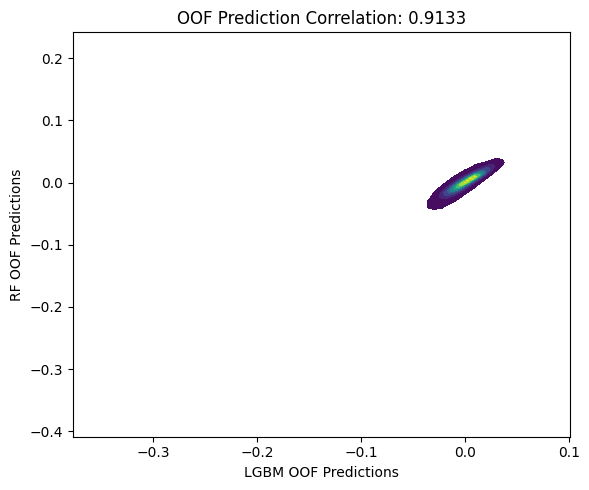

In [12]:
overall_corr = np.corrcoef(oof_lgb, oof_rf)[0, 1]
print(f"\nOverall OOF correlation between LGBM and RF: {overall_corr:.4f}")

plt.figure(figsize=(6, 5))
sns.kdeplot(x=oof_lgb, y=oof_rf, fill=True, cmap='viridis')
plt.title(f'OOF Prediction Correlation: {overall_corr:.4f}')
plt.xlabel('LGBM OOF Predictions')
plt.ylabel('RF OOF Predictions')
plt.tight_layout()
plt.show()

In [13]:
# =====================================================
# === Tune alpha weight between LGBM & RF ===
# =====================================================
def objective_alpha(trial):
    alpha = trial.suggest_float("alpha", 0.0, 1.0)
    blend = alpha * oof_lgb + (1 - alpha) * oof_rf
    return np.sqrt(mean_squared_error(oof_y, blend))

study_alpha = optuna.create_study(direction="minimize")
study_alpha.optimize(objective_alpha, n_trials=40)
best_alpha = study_alpha.best_params["alpha"]
print(f"✅ Best alpha for blending: {best_alpha:.4f}")

[I 2025-10-28 17:38:53,559] A new study created in memory with name: no-name-64a6f7ed-787a-4e9b-a172-6748a06690a6
[I 2025-10-28 17:38:53,568] Trial 0 finished with value: 0.056023550648007917 and parameters: {'alpha': 0.8238597794839118}. Best is trial 0 with value: 0.056023550648007917.
[I 2025-10-28 17:38:53,576] Trial 1 finished with value: 0.05607626045509812 and parameters: {'alpha': 0.4196939460636917}. Best is trial 0 with value: 0.056023550648007917.
[I 2025-10-28 17:38:53,583] Trial 2 finished with value: 0.05602754009508907 and parameters: {'alpha': 0.6382116761793827}. Best is trial 0 with value: 0.056023550648007917.
[I 2025-10-28 17:38:53,591] Trial 3 finished with value: 0.05602996910579337 and parameters: {'alpha': 0.6185997480619531}. Best is trial 0 with value: 0.056023550648007917.
[I 2025-10-28 17:38:53,598] Trial 4 finished with value: 0.05613917197320615 and parameters: {'alpha': 0.2656107245074466}. Best is trial 0 with value: 0.056023550648007917.
[I 2025-10-28 1

✅ Best alpha for blending: 0.7536


In [14]:
# =====================================================
# === Final blending using best alpha ===
# =====================================================
# recompute CV RMSE using best alpha
final_oof = best_alpha * oof_lgb + (1 - best_alpha) * oof_rf
final_rmse = np.sqrt(mean_squared_error(oof_y, final_oof))
print(f"Final blended OOF RMSE: {final_rmse:.5f}")

# re-blend test predictions using alpha
test_pred_final = best_alpha * test_pred_lgb + (1 - best_alpha) * test_pred_rf

Final blended OOF RMSE: 0.05602


In [15]:
# =====================================================
# === Ridge regression meta-blender ===
# =====================================================
from sklearn.linear_model import RidgeCV

print("\n--- Ridge Regression Meta-Blender ---")

meta_X = np.vstack([oof_lgb, oof_rf]).T
meta_y = oof_y

ridge = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
ridge.fit(meta_X, meta_y)
ridge_oof = ridge.predict(meta_X)
ridge_rmse = np.sqrt(mean_squared_error(meta_y, ridge_oof))
print(f"Ridge-blend OOF RMSE: {ridge_rmse:.5f}")
print("Ridge coefficients (LGBM, RF):", ridge.coef_)

# Predict on test set using same meta model
test_meta_X = np.vstack([test_pred_lgb, test_pred_rf]).T
test_pred_ridge = ridge.predict(test_meta_X)

# Optionally compare with Optuna alpha blend
print(f"Optuna alpha-blend OOF RMSE: {final_rmse:.5f}")
if ridge_rmse < final_rmse:
    print("✅ Ridge performs slightly better; using Ridge predictions.")
    test_pred_final = test_pred_ridge
else:
    print("ℹ️ Keeping Optuna alpha blend as final.")


--- Ridge Regression Meta-Blender ---
Ridge-blend OOF RMSE: 0.05602
Ridge coefficients (LGBM, RF): [0.75033773 0.24743416]
Optuna alpha-blend OOF RMSE: 0.05602
✅ Ridge performs slightly better; using Ridge predictions.


In [16]:
# =====================================================
# === Save OOF and test predictions for stacking ===
# =====================================================

# Save OOF predictions for meta-learning later
oof_df = pd.DataFrame({
    'id': train_cat['id'],
    'oof_lgb': oof_lgb,
    'oof_rf': oof_rf,
    'oof_blend': final_oof,
})

# Map y_base and accident_risk by ID (safe alignment)
ybase_map = dict(zip(train['id'], train['y_base']))
true_map = dict(zip(train['id'], train['accident_risk']))

# Add baseline offset to all model OOF predictions
for col in ["oof_lgb", "oof_rf", "oof_blend"]:
    oof_df[col] = oof_df[col] + oof_df["id"].map(ybase_map)

# Replace label with full-scale accident_risk
oof_df["y_true"] = oof_df["id"].map(true_map)

oof_df.to_csv('oof_lgb_rf.csv', index=False)
print("✅ Saved OOF predictions to oof_lgb_rf.csv")

# Save test predictions (for later external blending)
test_stack_df = pd.DataFrame({
    'id': test_cat['id'],
    'test_lgb': test_pred_lgb,
    'test_rf': test_pred_rf,
    'test_blend': test_pred_final
})

test_ybase_map = dict(zip(test_cat["id"], test["y_base"]))
for col in ["test_lgb", "test_rf", "test_blend"]:
    test_stack_df[col] = test_stack_df[col] + test_stack_df["id"].map(test_ybase_map)

test_stack_df.to_csv('test_lgb_rf.csv', index=False)
print("✅ Saved test predictions to test_lgb_rf.csv")

✅ Saved OOF predictions to oof_lgb_rf.csv
✅ Saved test predictions to test_lgb_rf.csv


In [17]:
# =====================================================
# === Save final blended predictions ===
# =====================================================

# Combine optimized test predictions with baseline offset
final_preds = test_pred_final + test["y_base"]

submission = pd.DataFrame({
    'id': test_cat['id'],
    'accident_risk': final_preds
})

submission.to_csv('submission_rfblend.csv', index=False)
print("✅ submission_rfblend.csv ready for Kaggle upload!")

✅ submission_rfblend.csv ready for Kaggle upload!
